# 1. Title: Wine Quality 

## 2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
## 3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  In the above reference, two datasets were created, using red and white wine samples.
  The inputs include objective tests (e.g. PH values) and the output is based on sensory data
  (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality 
  between 0 (very bad) and 10 (very excellent). Several data mining methods were applied to model
  these datasets under a regression approach. The support vector machine model achieved the
  best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
  etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
  analysis procedure).
 
## 4. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

## 5. Number of Instances: 
   red wine - 1599; white wine - 4898. 

## 6. Number of Attributes: 
   11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

## 7. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

## 8. Missing Attribute Values: 
   None
   
# Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

In [110]:
import matplotlib.pyplot  as plt
import pandas as pds
import seaborn as sns
import math
import numpy as np
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import subprocess

In [111]:
white_db = pds.read_csv("winequality-white.csv", sep=";", header=0)
red_db = pds.read_csv("winequality-red.csv", sep=';', header=0)

# Data

We have two data lists one white wines and the other red wines, lets have a look

In [3]:
print(white_db.shape)
print(red_db.shape)

(4898, 12)
(1599, 12)


In [4]:
white_db.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [5]:
red_db.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

We have imported two databases one consisting of 4898 white wines and the other of 1599 red wines.  These databases each have 11 physical measurements with continous distributions and one integer rating catagory for the quality of the wine.  Let's go ahead and take a look at what this data looks like by plotting each variable against every other variable.  Starting with the white wines

# White Wines

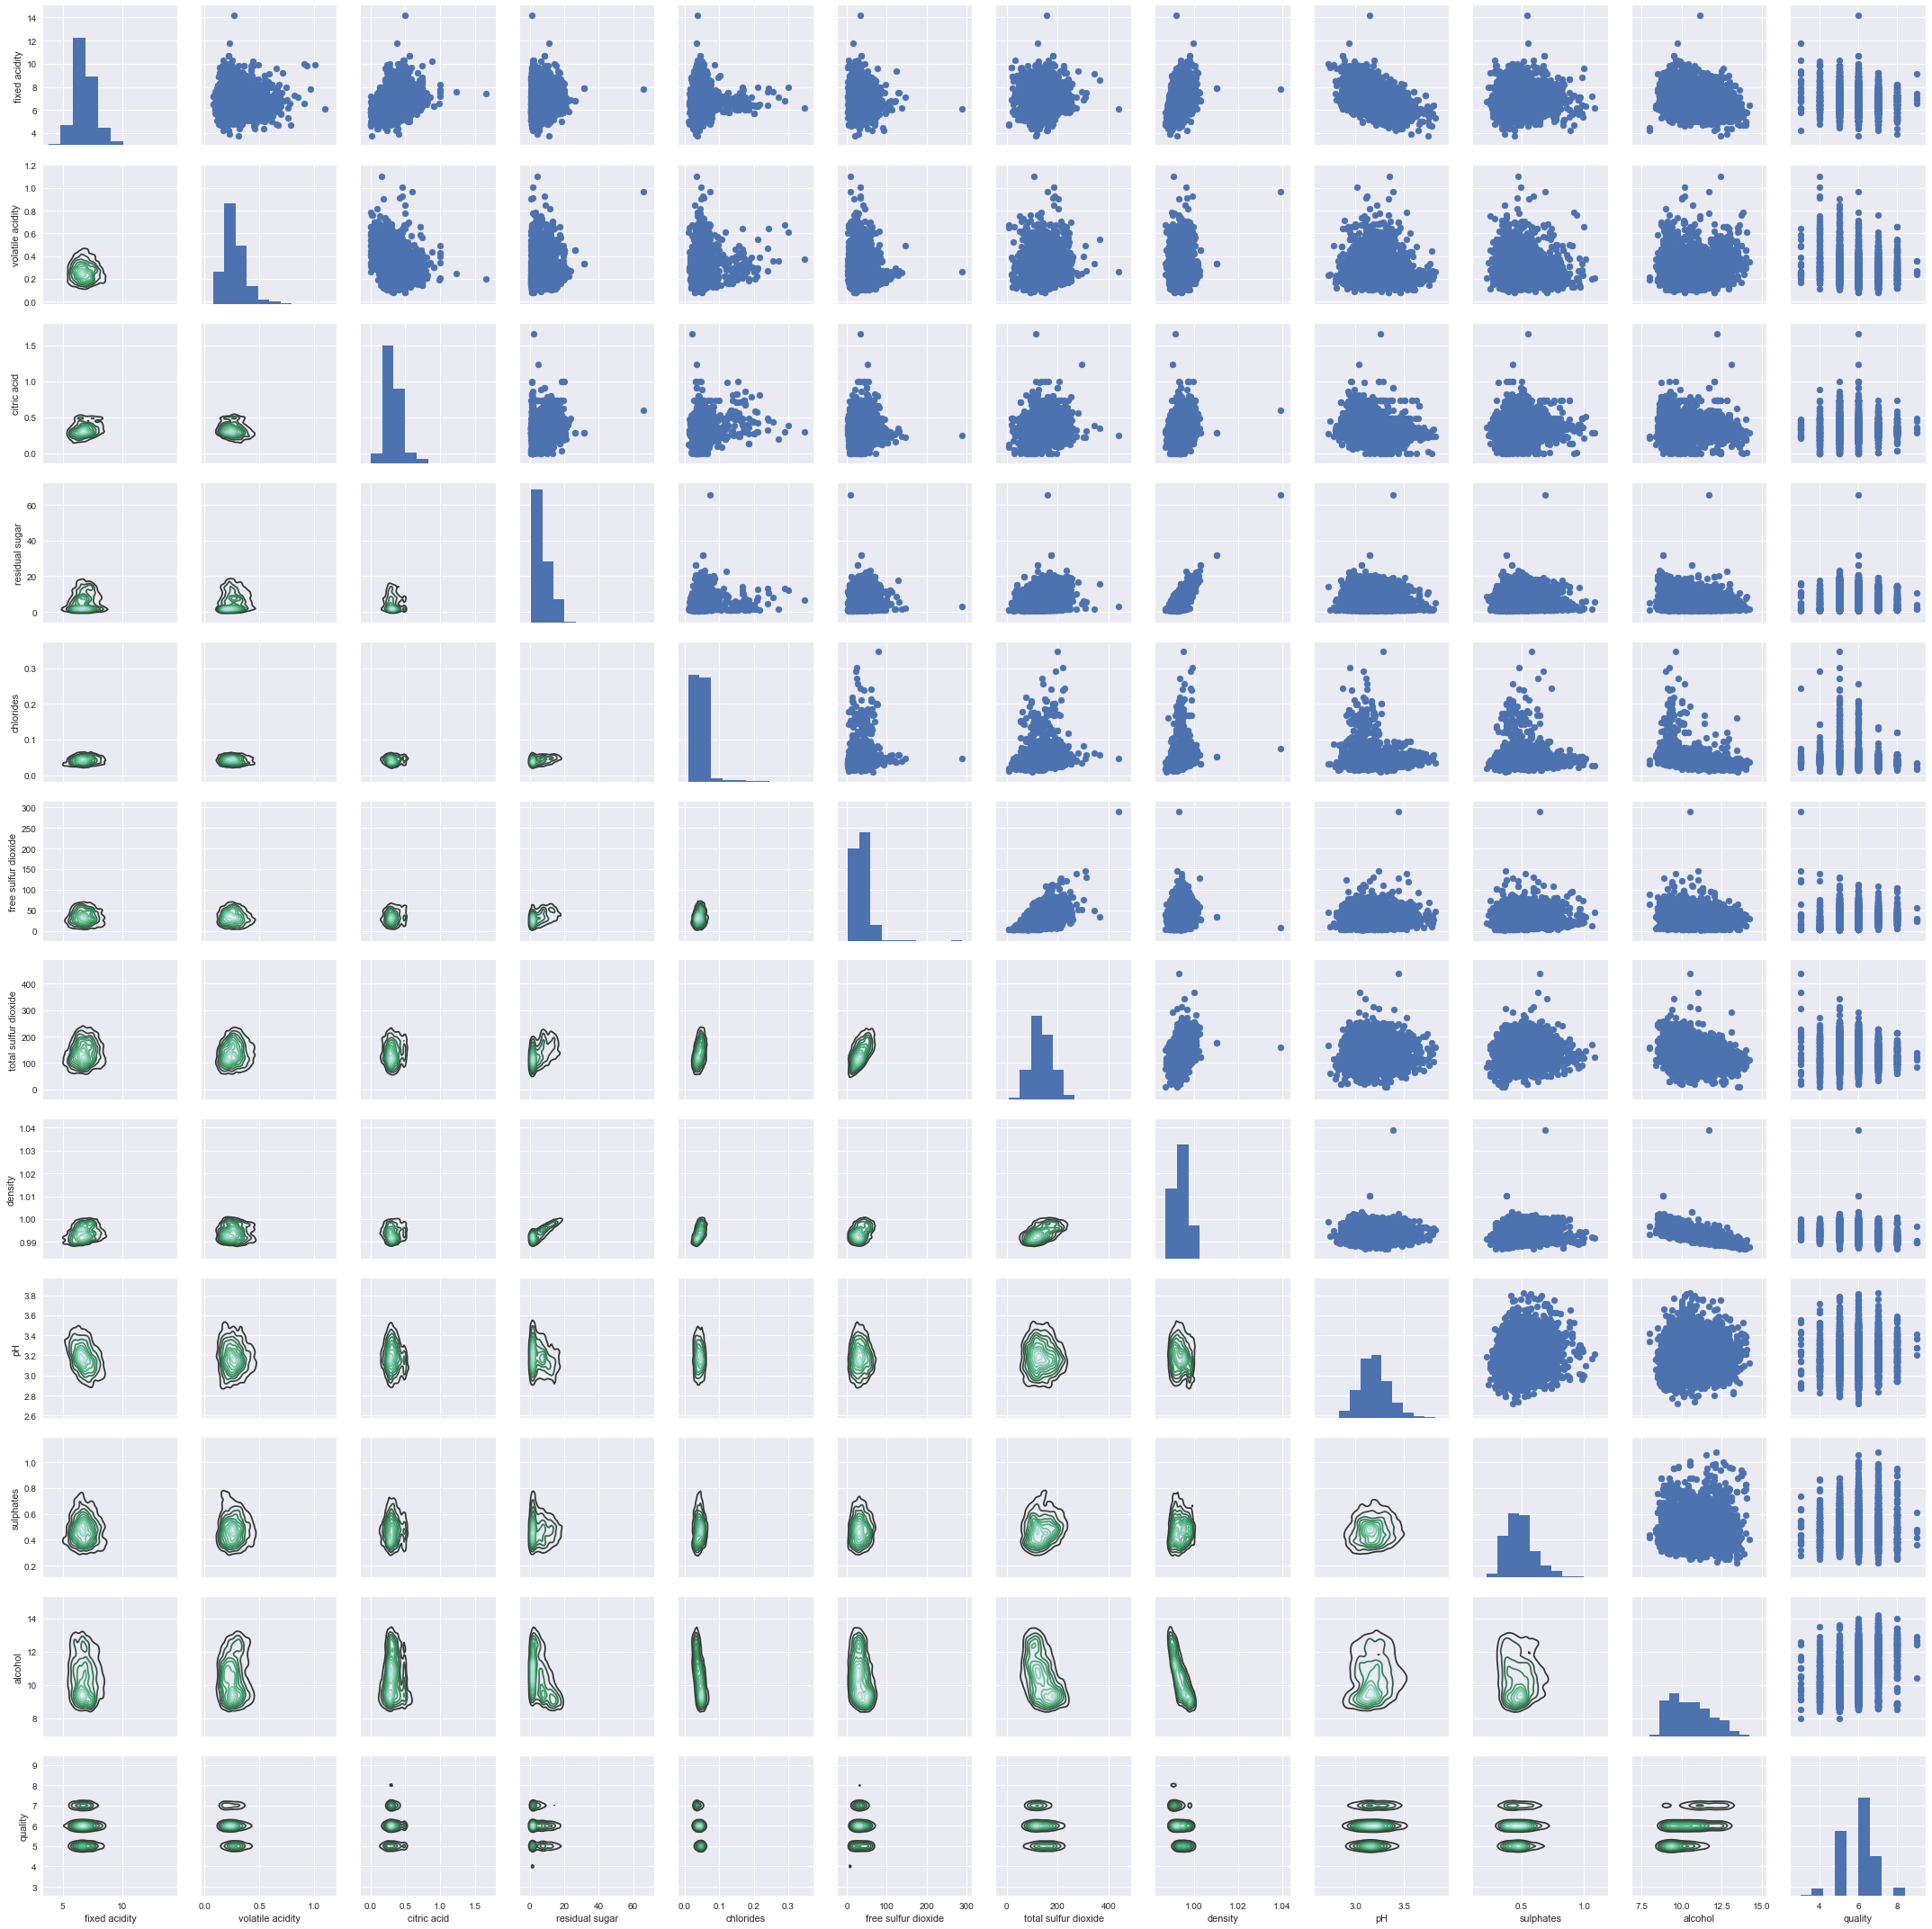

In [10]:
g = sns.PairGrid(white_db)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
plt.show()

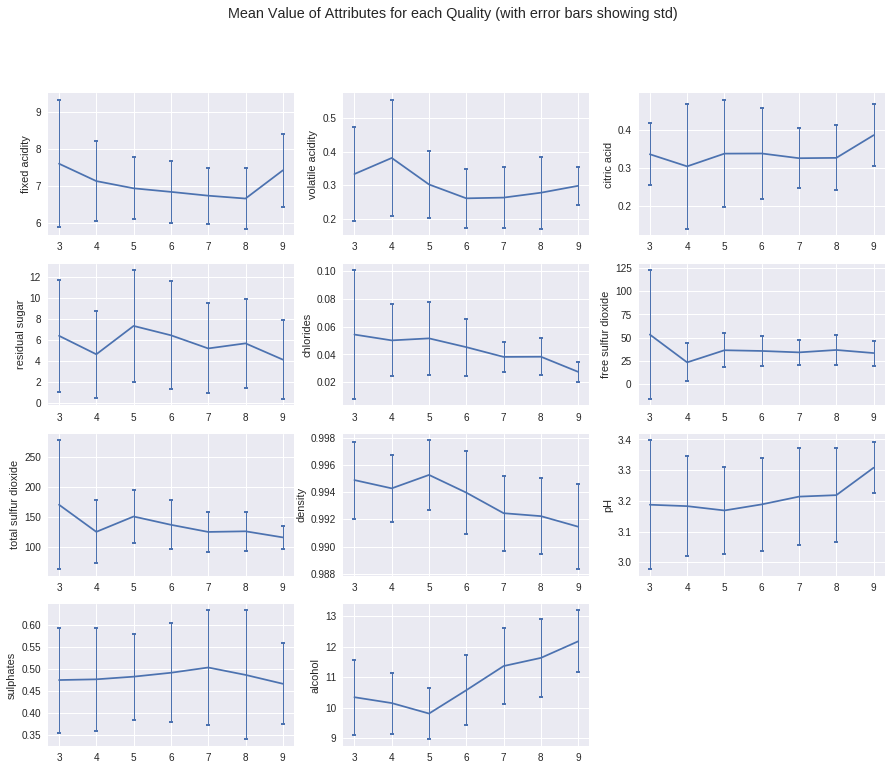

In [242]:
index = 0
for name in white_db.columns[:-1]:
#     plt.figure(1, figsize=(15, 12))
    index += 1
#     plt.subplot(4,3,index)
#     plt.ylabel(name)
    mean    = white_db.groupby('quality')[name].mean().values
    quality = white_db.groupby('quality')[name].mean().keys()
    std     = white_db.groupby('quality')[name].std().values
    yerr    = white_db.groupby('quality')[name].std().values / \
              white_db.groupby('quality')[name].count().apply(lambda x: math.sqrt(x)).values
    
#     plt.errorbar(quality, mean, yerr=yerr, capsize=2, capthick=2, elinewidth=1)
    
    plt.figure(2, figsize=(15, 12))
    plt.subplot(4,3,index)
    plt.ylabel(name)

    plt.errorbar(quality, mean, yerr=std, capsize=2, capthick=2, elinewidth=1)

plt.suptitle('Mean Value of Attributes for each Quality (with error bars showing std)')
plt.show()


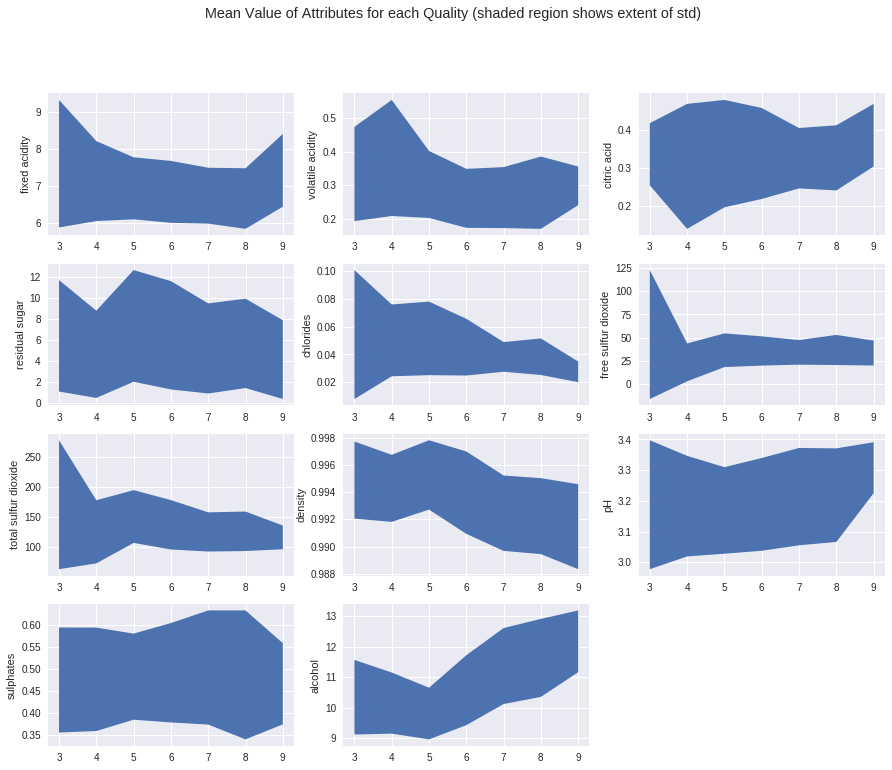

In [241]:
index = 0
for name in white_db.columns[:-1]:
#     plt.figure(1, figsize=(15, 12))
    index += 1
#     plt.subplot(4,3,index)
#     plt.ylabel(name)
    mean    = white_db.groupby('quality')[name].mean().values
    quality = white_db.groupby('quality')[name].mean().keys()
    std     = white_db.groupby('quality')[name].std().values
    yerr    = white_db.groupby('quality')[name].std().values / \
              white_db.groupby('quality')[name].count().apply(lambda x: math.sqrt(x)).values
    
#     plt.fill_between(quality, mean+yerr, mean-yerr)
    
    plt.figure(2, figsize=(15, 12))
    plt.subplot(4,3,index)
    plt.ylabel(name)
    
    plt.fill_between(quality, mean+std, mean-std)
plt.suptitle('Mean Value of Attributes for each Quality (shaded region shows extent of std)')
plt.show()

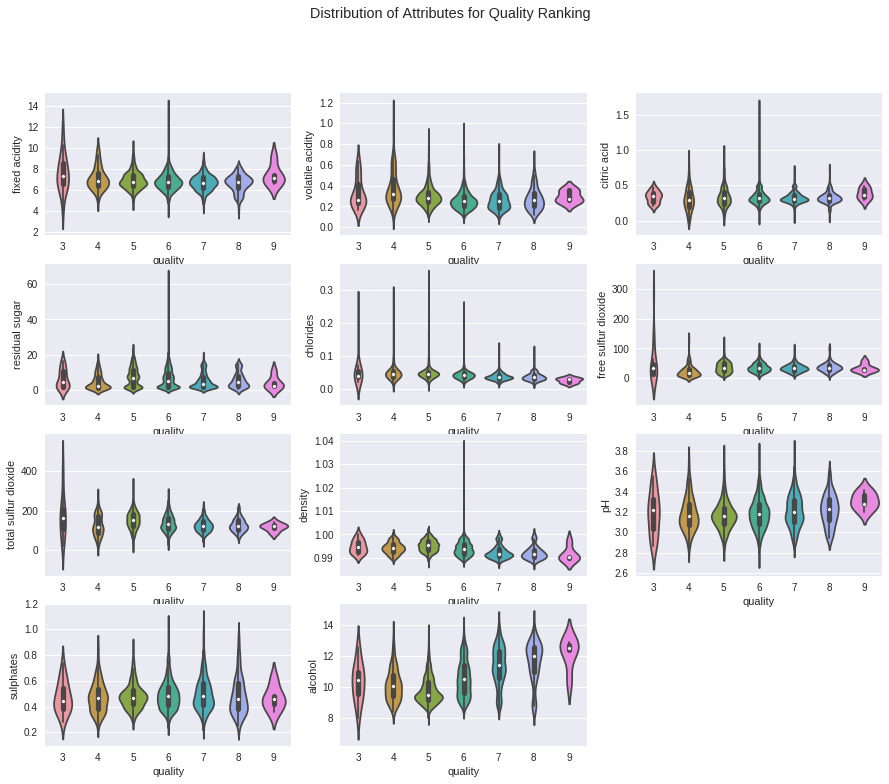

In [243]:
index = 0
for name in white_db.columns[:-1]:
    plt.figure(1, figsize=(15, 12))
    index += 1
    plt.subplot(4,3,index)
    plt.ylabel(name)
    
    sns.violinplot(x=white_db['quality'], y=white_db[name])
plt.suptitle('Distribution of Attributes for Quality Ranking')
plt.show()

In [251]:
print("Correlation to Wine Quality\n")
for name in white_db.columns[:-1]:
    print(name)
    print(white_db['quality'].corr(white_db[name]),"\n")

Correlation to Wine Quality

fixed acidity
-0.113662830713 

volatile acidity
-0.194722968921 

citric acid
-0.00920909088398 

residual sugar
-0.0975768288947 

chlorides
-0.209934410947 

free sulfur dioxide
0.00815806712344 

total sulfur dioxide
-0.174737217597 

density
-0.307123312735 

pH
0.0994272457367 

sulphates
0.0536778771328 

alcohol
0.435574715461 



# What is the Data Telling Us?

Well just looking at the white wines and how it relates to the quality assesment we see that there is a ton of variance in each of the attribute for most quality values.  

It is a little bit of different story when we look at the correlations to quality though.  This is taking into account every data point, and so is bit less sensitive to the variance than what we saw in the mean values.  From this it appears that the number one leading factor for determining the quality of the wine is the alcohol content.  The more alcoholic your wine, the more people like it... maybe that's not too terriblying surprising...  Though the correlation is not overwhelming strong, just the strongest.  This is followed closely by a negative correlation with the density, so a lighter wine is generally considered a better wine.  Finally it looks like total sulfur dioxide, chlorides, and volatile and fixed acidity are all things you want to minimize in a better wine.  Kind of oddly while total sulfur dioxide is a major secondary attribute detremental to wine quality, free sulfur dioxide hardly seems to have any correlation to the quality of the wine.

I'm curious if we can find and remove outliers, calm the data some what and perhaps paint a better picture of what really makes a good wine. Looking at the scatter plots at the top of this section it is pretty clear that there are a few outliers.  Its probably worthwhile at some point removing those points and looking again somewhere down the line.

In [90]:
print(white_db.groupby('quality')['quality'].count())

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64


First off I don't think its reasonible to expect 5 data points for the '9' rating to form a sensible sample.  It would probably be better to get rid of those points, perhaps the '3' rating as well.

In [108]:
att = white_db.columns[:-1]
cov = white_db[att].cov()
print(cov)
eigen = np.linalg.eigvals(cov)
for i in eigen:
    print(math.sqrt(i*24.725))
# np.linalg.det(cov)

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              0.712114         -0.001931     0.029533   
volatile acidity          -0.001931          0.010160    -0.001823   
citric acid                0.029533         -0.001823     0.014646   
residual sugar             0.381022          0.032865     0.057829   
chlorides                  0.000426          0.000155     0.000302   
free sulfur dioxide       -0.708919         -0.166300     0.193630   
total sulfur dioxide       3.266013          0.382354     0.622989   
density                    0.000670          0.000008     0.000054   
pH                        -0.054265         -0.000486    -0.002992   
sulphates                 -0.001651         -0.000411     0.000861   
alcohol                   -0.125533          0.008400    -0.011278   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.381022   0.000426            -0.708919   
volatile acidit

# Red Wines

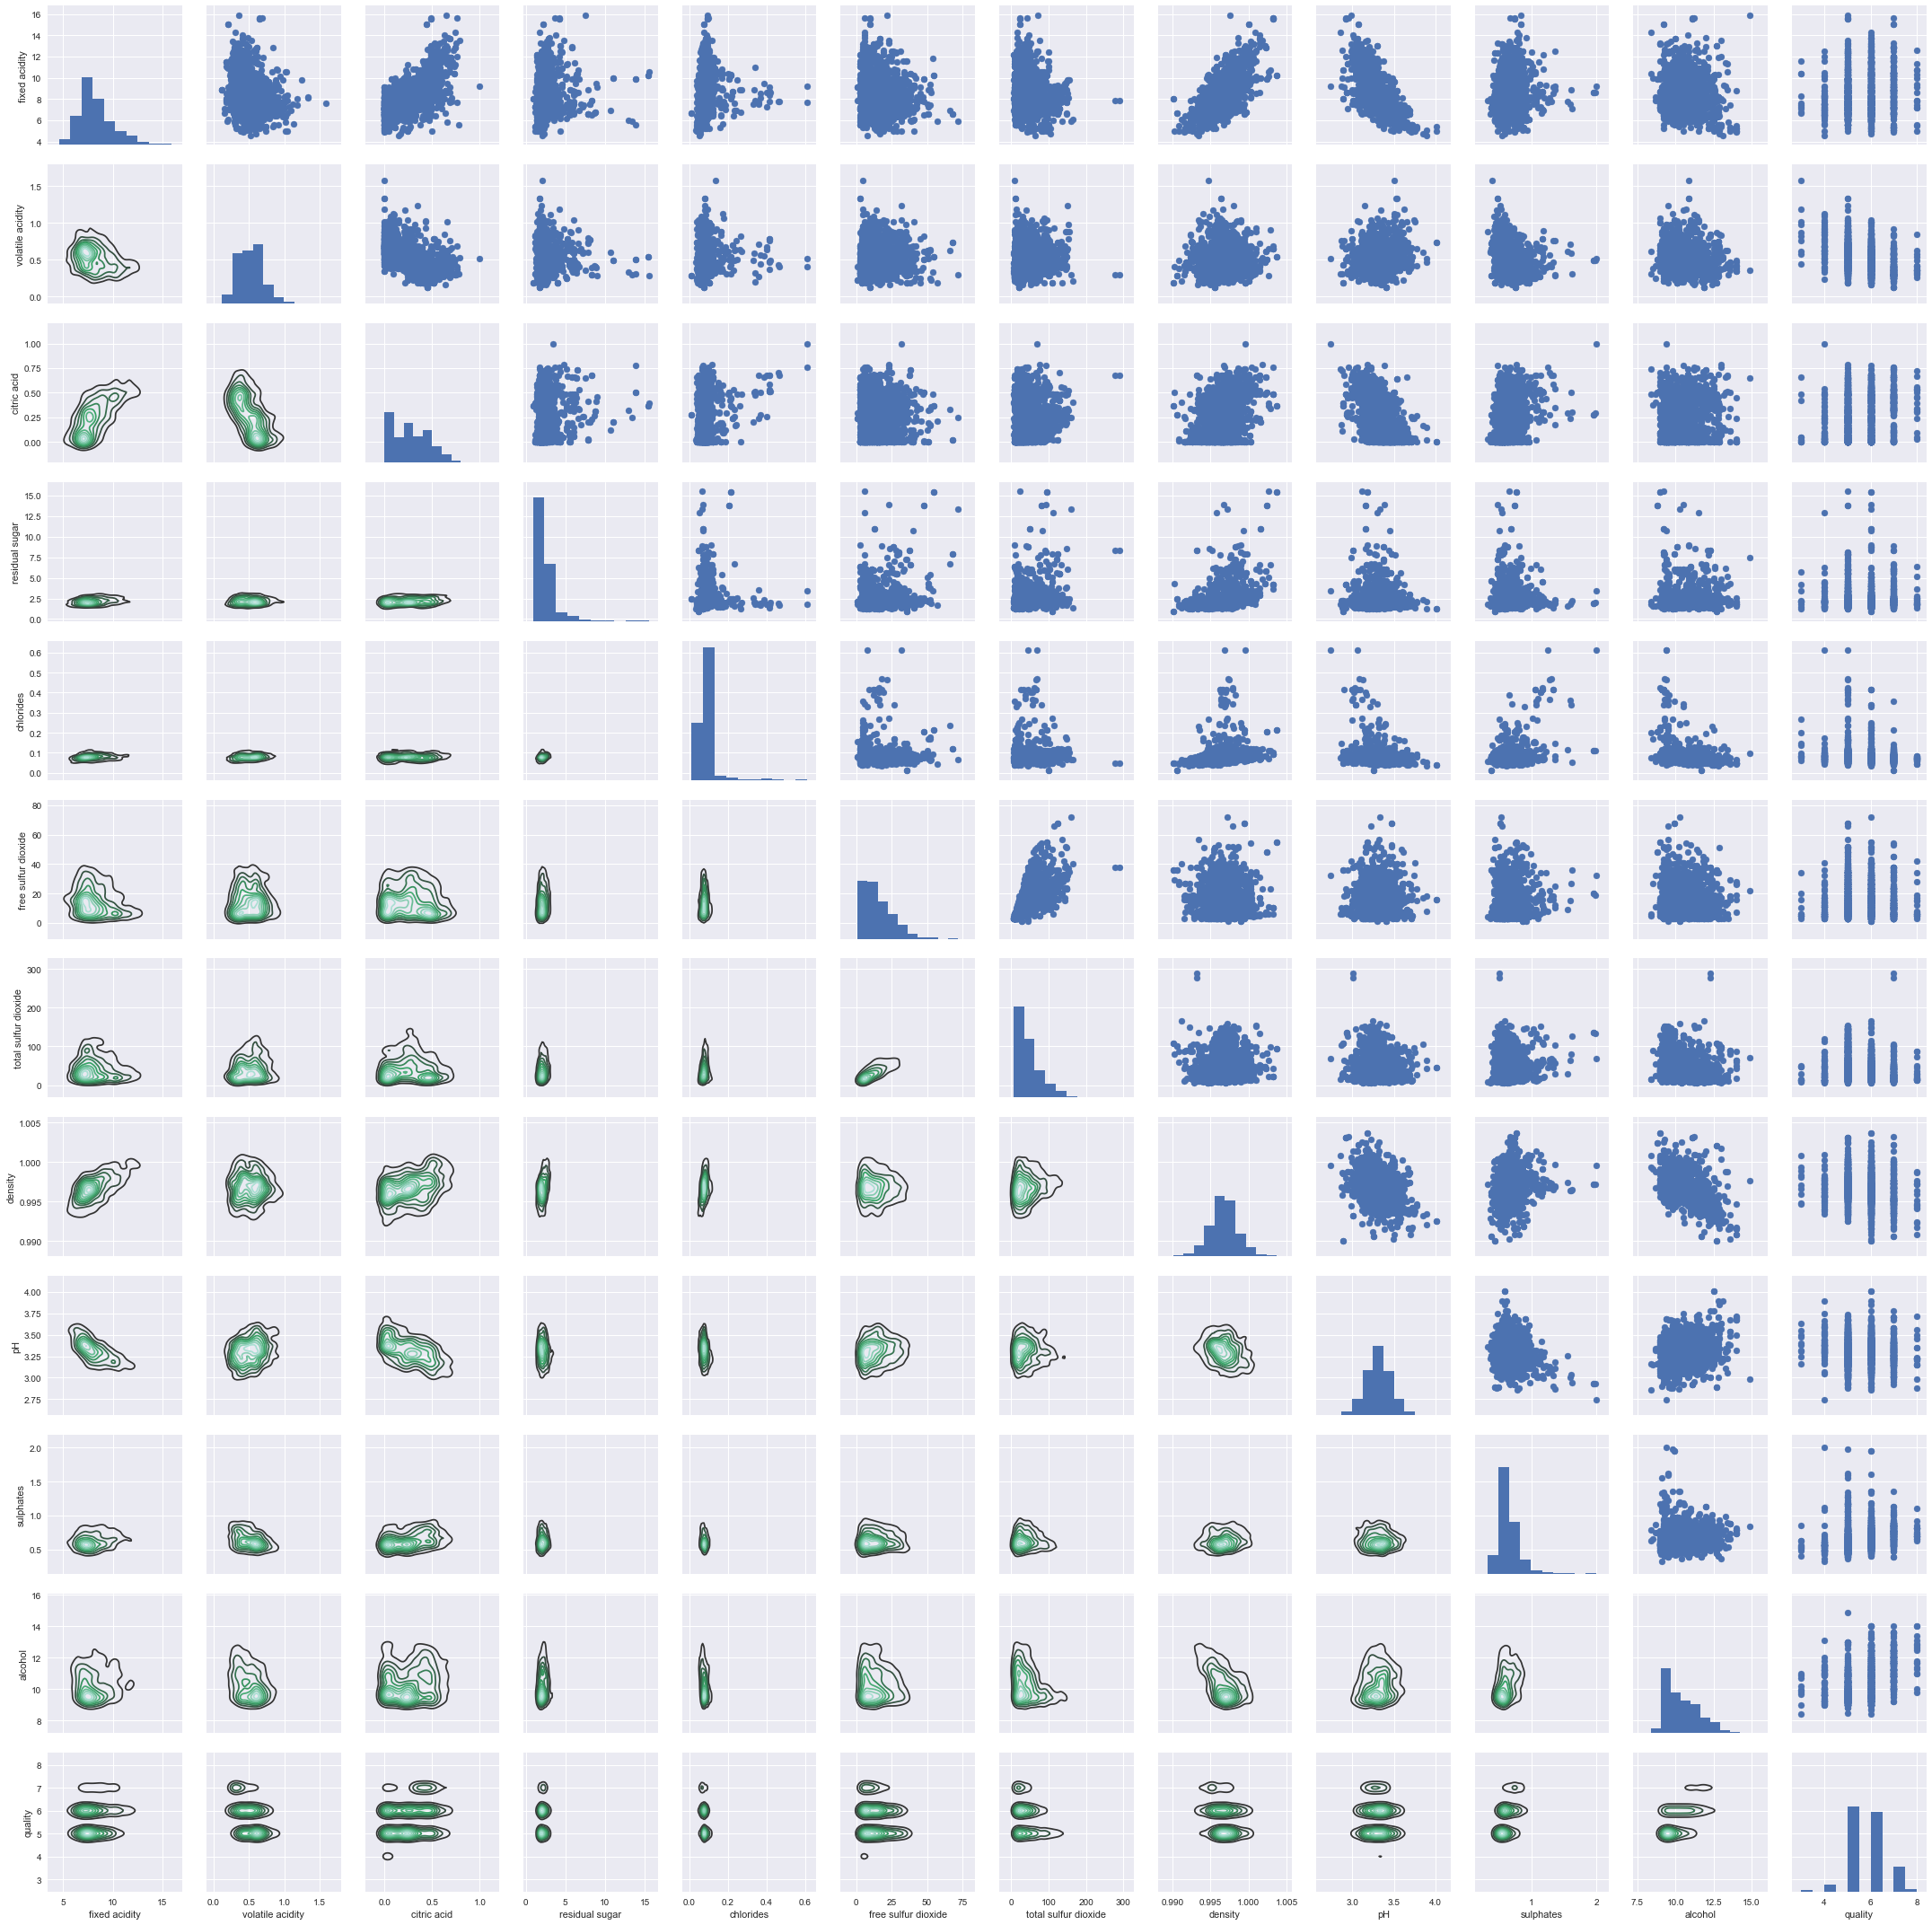

In [11]:
g = sns.PairGrid(red_db)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
plt.show()

In [7]:
red_db[attributes].corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


In [58]:
print(white_db.mean(),"\n\n", white_db.std())

fixed acidity             6.854788
volatile acidity          0.278241
citric acid               0.334192
residual sugar            6.391415
chlorides                 0.045772
free sulfur dioxide      35.308085
total sulfur dioxide    138.360657
density                   0.994027
pH                        3.188267
sulphates                 0.489847
alcohol                  10.514267
quality                   5.877909
dtype: float64 

 fixed acidity            0.843868
volatile acidity         0.100795
citric acid              0.121020
residual sugar           5.072058
chlorides                0.021848
free sulfur dioxide     17.007137
total sulfur dioxide    42.498065
density                  0.002991
pH                       0.151001
sulphates                0.114126
alcohol                  1.230621
quality                  0.885639
dtype: float64


In [37]:
y=total_db['color']
x=total_db[attributes]
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [4]:
temp_db = white_db.copy()
temp_db['color_value'] = 0
temp_db['color'] = 'white'
total_db = temp_db.copy()
temp_db = red_db.copy()
temp_db['color_value'] = 1
temp_db['color'] = 'red'
total_db = total_db.append(temp_db, ignore_index=True)

In [5]:
attributes = list(total_db.columns[:-3])
print(attributes)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [59]:
print(red_db.mean(), '\n\n', red_db.std())

fixed acidity            8.319637
volatile acidity         0.527821
citric acid              0.270976
residual sugar           2.538806
chlorides                0.087467
free sulfur dioxide     15.874922
total sulfur dioxide    46.467792
density                  0.996747
pH                       3.311113
sulphates                0.658149
alcohol                 10.422983
quality                  5.636023
dtype: float64 

 fixed acidity            1.741096
volatile acidity         0.179060
citric acid              0.194801
residual sugar           1.409928
chlorides                0.047065
free sulfur dioxide     10.460157
total sulfur dioxide    32.895324
density                  0.001887
pH                       0.154386
sulphates                0.169507
alcohol                  1.065668
quality                  0.807569
dtype: float64


In [101]:
print(white_db.mean()-red_db.mean(), '\n\n', (white_db.std()**2 + red_db.std()**2)**.5)

fixed acidity           -1.464850
volatile acidity        -0.249579
citric acid              0.063216
residual sugar           3.852609
chlorides               -0.041694
free sulfur dioxide     19.433163
total sulfur dioxide    91.892865
density                 -0.002719
pH                      -0.122847
sulphates               -0.168302
alcohol                  0.091284
quality                  0.241887
dtype: float64 

 fixed acidity            1.934820
volatile acidity         0.205480
citric acid              0.229332
residual sugar           5.264377
chlorides                0.051889
free sulfur dioxide     19.966412
total sulfur dioxide    53.741863
density                  0.003537
pH                       0.215955
sulphates                0.204346
alcohol                  1.627905
quality                  1.198551
dtype: float64


In [109]:
distance = white_db.mean()-red_db.mean()
spread = (white_db.std()**2 + red_db.std()**2)**(.5)
ratio = distance/spread
print(ratio)

fixed acidity          -0.757098
volatile acidity       -1.214618
citric acid             0.275652
residual sugar          0.731826
chlorides              -0.803525
free sulfur dioxide     0.973293
total sulfur dioxide    1.709894
density                -0.768903
pH                     -0.568854
sulphates              -0.823612
alcohol                 0.056074
quality                 0.201816
dtype: float64


So what it looks like here is that the number one way to tell the difference between red and white wine is by measuring the total sulfur dioxide.  Secondary ways of telling the difference is through measurements of the free sulfur dioxide, chlorides, density, sulphates, and fixed acidity, perhaps residual sugar as well.  Of almost no imporantace is alcohol content or levels of citric acid.

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0             0.270         0.36           20.70      0.045   
1               6.3             0.300         0.34            1.60      0.049   
2               8.1             0.280         0.40            6.90      0.050   
3               7.2             0.230         0.32            8.50      0.058   
4               7.2             0.230         0.32            8.50      0.058   
5               8.1             0.280         0.40            6.90      0.050   
6               6.2             0.320         0.16            7.00      0.045   
7               7.0             0.270         0.36           20.70      0.045   
8               6.3             0.300         0.34            1.60      0.049   
9               8.1             0.220         0.43            1.50      0.044   
10              8.1             0.270         0.41            1.45      0.033   
11              8.6         

In [ ]:
temp = white_db["total sulfur dioxide", "color"]

In [60]:
from sklearn import datasets
iris = datasets.load_iris()

In [95]:
print(iris.target)
print(list(total_db["color"]))
print(iris.data)
print(total_db)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [66]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)

In [67]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [68]:
print(gnb.fit(iris.data, iris.target))

GaussianNB(priors=None)


In [75]:
white_data = np.array_split(white_db, 2)[0]
white_pred = np.array_split(white_db, 2)[1]

In [92]:
data_labels = white_data.columns[:-1]
target_labels = white_db.columns[-1:]
y_pred = gnb.fit(white_data[data_labels], list(white_data[target_labels])).predict(white_pred[data_labels])

ValueError: Found input variables with inconsistent numbers of samples: [2449, 1]